# Image Captioning Using Deep Learning

## 1. Data Preperation

Here we use the 2017 MSCOCO dataset

In [ ]:
import os
import json
import pandas as pd
import re
import numpy as np
import random
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


In [ ]:
# Constants

BATCH_SIZE = 64
BUFFER_SIZE = 1000
VOCABULARY_SIZE = 10000
MAX_LENGTH = 40
EMBEDDING_DIM = 256
UNITS = 512
EPOCHS = 20

In [182]:
# Define path to dataset
BASE_PATH = '/kaggle/input/coco-2017-dataset/coco2017'
ANNOTATION_FILE = os.path.join(BASE_PATH, 'annotations/captions_train2017.json')
IMAGE_DIR = os.path.join(BASE_PATH, 'train2017')

In [183]:
# Load captions
with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)['annotations']

### Dataset Exploration
First, let's examine the structure and content of our COCO dataset to understand what data we're working with.

In [184]:
# Print the total number of captions
print(f"Total captions in dataset: {len(data)}\n")

# Print the first 10 sample captions
print("Sample captions:\n")
for i in range(5):
    print(f"{i+1}. {data[i]['caption']}")


Total captions in dataset: 591753

Sample captions:

1. A bicycle replica with a clock as the front wheel.
2. A room with blue walls and a white sink and door.
3. A car that seems to be parked illegally behind a legally parked car
4. A large passenger airplane flying through the air.
5. There is a GOL plane taking off in a partly cloudy sky.


### Image-Caption Mapping
Now let's explore how images are mapped to their corresponding captions in the dataset. Each image ID corresponds to a specific image file and can have multiple captions.

In [185]:
# Show 5 sample captions with their image IDs
for i in range(5):
    print(f"{i+1}. Image ID: {data[i]['image_id']} --> Caption: {data[i]['caption']}")


1. Image ID: 203564 --> Caption: A bicycle replica with a clock as the front wheel.
2. Image ID: 322141 --> Caption: A room with blue walls and a white sink and door.
3. Image ID: 16977 --> Caption: A car that seems to be parked illegally behind a legally parked car
4. Image ID: 106140 --> Caption: A large passenger airplane flying through the air.
5. Image ID: 106140 --> Caption: There is a GOL plane taking off in a partly cloudy sky.


### Dataset Size Verification
Let's verify the total number of images available in our training dataset directory.

In [186]:
# total images in train2017
image_files = os.listdir(IMAGE_DIR)
print(f"Total image files in train2017 folder: {len(image_files)}")

Total image files in train2017 folder: 118287


In [187]:
# Map image IDs to image paths and captions
img_cap_pairs = []
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(lambda x: f'{BASE_PATH}/train2017/{x}')
captions = captions.sample(70000).reset_index(drop=True)


In [188]:
print(f"Total captions loaded: {len(captions)}")

Total captions loaded: 70000


### Data Sampling
We sample 70,000 image-caption pairs from the full dataset to make training manageable while maintaining diversity.

In [189]:
captions

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/train...,Soccer players in blue and yellow going after ...
1,/kaggle/input/coco-2017-dataset/coco2017/train...,A large green truck parked near a road.
2,/kaggle/input/coco-2017-dataset/coco2017/train...,A man riding a snowboard on a snow covered slope.
3,/kaggle/input/coco-2017-dataset/coco2017/train...,Woman in front of pizza with several toppings ...
4,/kaggle/input/coco-2017-dataset/coco2017/train...,A pile of skis sitting on top of each other.
...,...,...
69995,/kaggle/input/coco-2017-dataset/coco2017/train...,A cat laying on a bed in a messy room
69996,/kaggle/input/coco-2017-dataset/coco2017/train...,"a yellow ""floodway"" sign stands erect near a road"
69997,/kaggle/input/coco-2017-dataset/coco2017/train...,A man standing in a field holding a colorful b...
69998,/kaggle/input/coco-2017-dataset/coco2017/train...,A grassy field with sheep and other animals ru...


### Data Structure Overview
Let's examine the structure of our processed dataframe containing image paths and their corresponding captions.

In [ ]:
# Show 5 sample captions with their image IDs
for i in range(5):
    print(f"{i+1}. Image ID: {data[i]['image_id']} --> Caption: {data[i]['caption']}")

1. Image ID: 203564 --> Caption: A bicycle replica with a clock as the front wheel.
2. Image ID: 322141 --> Caption: A room with blue walls and a white sink and door.
3. Image ID: 16977 --> Caption: A car that seems to be parked illegally behind a legally parked car
4. Image ID: 106140 --> Caption: A large passenger airplane flying through the air.
5. Image ID: 106140 --> Caption: There is a GOL plane taking off in a partly cloudy sky.


### Visual Sample
Let's visualize a sample image along with its caption to better understand our data.

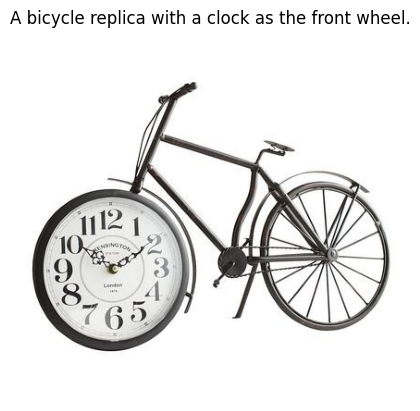

In [191]:
# Optional: Display the image for one of the captions
image_id = data[0]['image_id']
image_filename = f"{image_id:012}.jpg"  # pad to 12 digits
image_path = os.path.join(IMAGE_DIR, image_filename)

# Show image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(data[0]['caption'])
plt.show()

In [192]:
# Clean and preprocess captions
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9]+", ' ', text)
    text = text.strip()
    text = '<start> ' + text + ' <end>'
    return text

captions['caption'] = captions['caption'].apply(preprocess)

## 2. Text Preprocessing
Before training our model, we need to clean and standardize the caption text. This involves converting to lowercase, removing special characters, and adding start/end tokens.

In [ ]:
# Initialize and adapt tokenizer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LENGTH,
    standardize=None
)
text_vectorizer.adapt(captions['caption'])

In [ ]:
print(captions['caption'].head())

0    <start> soccer players in blue and yellow goin...
1    <start> a large green truck parked near a road...
2    <start> a man riding a snowboard on a snow cov...
3    <start> woman in front of pizza with several t...
4    <start> a pile of skis sitting on top of each ...
Name: caption, dtype: object


### Preprocessed Caption Examples
Let's examine how our captions look after preprocessing with start/end tokens and cleaned text.

In [195]:

# Save vocab mappings
vocab = text_vectorizer.get_vocabulary()
word2idx = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token="")
idx2word = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token="", invert=True)

## 3. Data Pipeline Creation
Now we'll create TensorFlow datasets for training and validation, including image preprocessing and caption tokenization.

In [196]:
# Split into train and validation sets
from collections import defaultdict
img_to_cap = defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap[img].append(cap)

keys = list(img_to_cap.keys())
random.shuffle(keys)
split_index = int(0.8 * len(keys))
train_keys = keys[:split_index]
val_keys = keys[split_index:]

train_imgs, train_caps = [], []
for k in train_keys:
    for c in img_to_cap[k]:
        train_imgs.append(k)
        train_caps.append(c)

val_imgs, val_caps = [], []
for k in val_keys:
    for c in img_to_cap[k]:
        val_imgs.append(k)
        val_caps.append(c)

In [ ]:
# Preprocess image + tokenize caption together
def load_and_preprocess(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    cap = text_vectorizer(caption)
    return img, cap

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_caps))
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_imgs, val_caps))
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 4. Model Architecture
Our image captioning model consists of three main components:
1. **CNN Encoder**: Extracts visual features from images using pre-trained InceptionV3
2. **Attention Mechanism**: Focuses on relevant image regions while generating captions
3. **LSTM Decoder**: Generates word sequences based on visual features and attention

In [ ]:
def CNN_Encoder():
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    base_model.trainable = False
    output = base_model.output
    output = tf.keras.layers.Reshape((-1, output.shape[-1]))(output)
    return tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## 5. Model Training
The training process uses teacher forcing, where the model learns to predict the next word in a caption given the previous words and image features. 


In [ ]:
cnn_encoder = CNN_Encoder()
decoder = Decoder(EMBEDDING_DIM, UNITS, VOCABULARY_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [204]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)
    
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word2idx('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = cnn_encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_vars = cnn_encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    return loss, total_loss

### Training Loop
At each Batch Loss is shown, as it decreases over each batch and every epoch.

In [ ]:
train_loss_plot = []
for epoch in range(EPOCHS):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    epoch_loss = total_loss / batch
    train_loss_plot.append(epoch_loss)
    print(f'Epoch {epoch+1} Loss {epoch_loss:.6f}')

Epoch 1 Batch 0 Loss 26.8372
Epoch 1 Batch 100 Loss 29.5715
Epoch 1 Batch 200 Loss 33.1283
Epoch 1 Batch 300 Loss 30.2086
Epoch 1 Batch 400 Loss 28.9259
Epoch 1 Batch 500 Loss 29.7073
Epoch 1 Batch 600 Loss 27.6713
Epoch 1 Batch 700 Loss 28.9322
Epoch 1 Batch 800 Loss 28.8904
Epoch 1 Loss 0.753841
Epoch 2 Batch 0 Loss 28.5402
Epoch 2 Batch 100 Loss 26.6644
Epoch 2 Batch 200 Loss 31.7699
Epoch 2 Batch 300 Loss 29.4444
Epoch 2 Batch 400 Loss 30.8090
Epoch 2 Batch 500 Loss 27.4911
Epoch 2 Batch 600 Loss 29.0815
Epoch 2 Batch 700 Loss 25.7084
Epoch 2 Batch 800 Loss 28.5769
Epoch 2 Loss 0.717888
Epoch 3 Batch 0 Loss 30.2606
Epoch 3 Batch 100 Loss 29.0711
Epoch 3 Batch 200 Loss 28.2740
Epoch 3 Batch 300 Loss 29.8336
Epoch 3 Batch 400 Loss 28.3270
Epoch 3 Batch 500 Loss 27.8052
Epoch 3 Batch 600 Loss 24.1213
Epoch 3 Batch 700 Loss 29.0543
Epoch 3 Batch 800 Loss 26.7075
Epoch 3 Loss 0.682140
Epoch 4 Batch 0 Loss 27.6507
Epoch 4 Batch 100 Loss 24.9130
Epoch 4 Batch 200 Loss 28.6886
Epoch 4 Batc

In [ ]:
def generate_caption(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.expand_dims(img, 0)
    features = cnn_encoder(img)

    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([word2idx('<start>')], 0)
    result = []
    for _ in range(MAX_LENGTH):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        predicted_word = idx2word(predicted_id).numpy().decode('utf-8')
        if predicted_word == '<end>':
            break
        result.append(predicted_word)
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(result)


## 6. Model Evaluation
After training, we evaluate our model's performance using the BLEU score metric, which measures the similarity between generated captions and reference captions.

### BLEU Score Calculation
BLEU (Bilingual Evaluation Understudy) score measures caption quality by comparing n-gram overlap between generated and reference captions. Higher scores indicate better performance.

In [210]:
# Compute BLEU score on validation set
references = []
candidates = []
for img, cap in zip(val_imgs[:200], val_caps[:200]):
    pred = generate_caption(img)
    candidates.append(pred.split())
    references.append([cap.replace('<start>', '').replace('<end>', '').split()])

bleu_score = corpus_bleu(references, candidates)
print(f'BLEU Score: {bleu_score:.4f}')

BLEU Score: 0.0264


### Qualitative Analysis
Let's examine some specific examples to see how well our model performs compared to the reference captions.

In [223]:
#manual review of predicted captions
for i in range(5):
    print("Generated:", ' '.join(candidates[i]))
    print("Reference:", ' '.join(references[i][0]))
    print()


Generated: small bananas is perched on a ledge
Reference: someone wrote a message on a bunch of bananas

Generated: small bananas is perched on a ledge
Reference: a bundle of bananas has i love you written on it

Generated: a man is riding bikes parked at each side
Reference: two people that are riding bikes on a path

Generated: a man is riding bikes parked at each side
Reference: two people riding on bicycles near a row of trees

Generated: the kite is flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying kites flying
Reference: a couple of kites fly through the air



### Visual Results
Display images alongside predicted and actual captions for visual assessment of model performance.

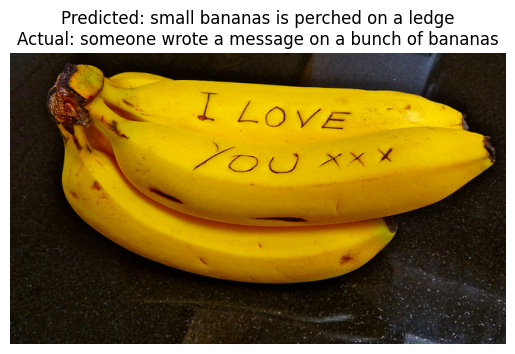

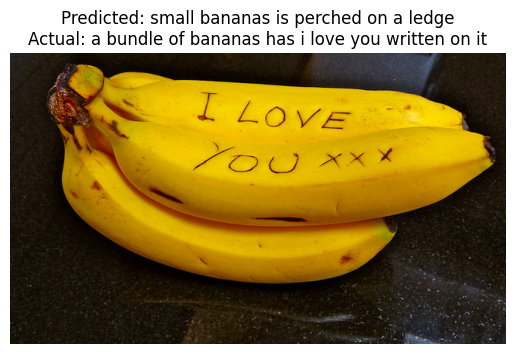

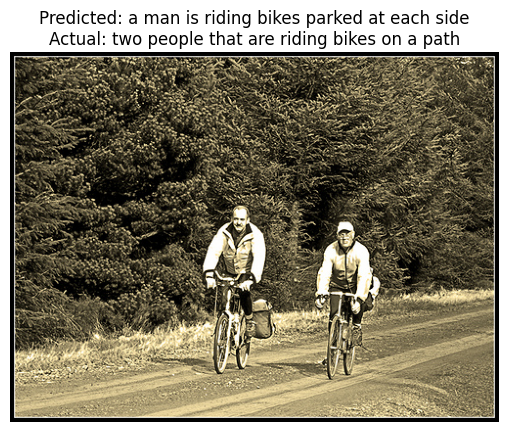

In [224]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(3):
    img_path = val_imgs[i]
    pred_caption = ' '.join(candidates[i])
    true_caption = ' '.join(references[i][0])
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_caption}\nActual: {true_caption}")
    plt.show()


Predited words do have similar context to the actual sentences. But sometime's it ends up repeating itself

## 7. Training Analysis
Visualize the training loss over epochs to understand model convergence and identify potential overfitting.

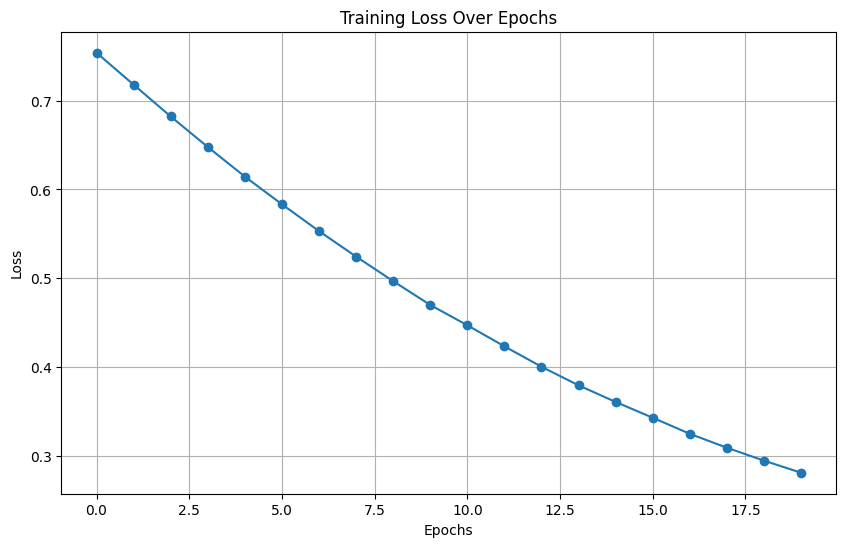

In [227]:
# ✅ Step 8: VISUALIZATION
plt.figure(figsize=(10,6))
plt.plot(train_loss_plot, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

The above graphs show's how the model does decrease it's loss over epochs, starting well above 0.7 while ending lower than 0.3

### Testing on Unseen Data
Now let's test our trained model on completely unseen images from the test set to evaluate generalization capability.


Image: 000000355443.jpg
Generated Caption: a rusted sitting on it


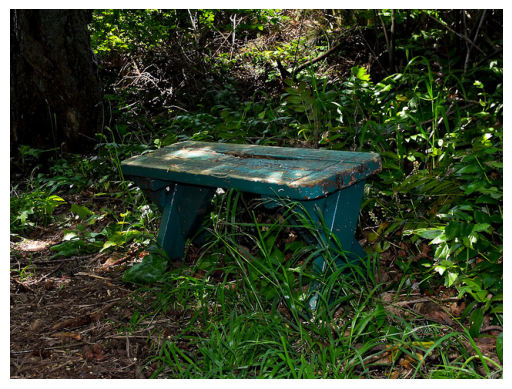


Image: 000000081349.jpg
Generated Caption: two motorcycles down the road


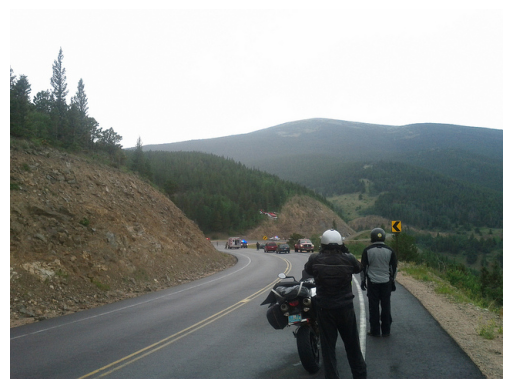


Image: 000000436639.jpg
Generated Caption: a close up of a piece of pizza with a side of a piece of pizza with a side of a piece of pizza with a side of a piece of pizza with a side of a piece of pizza


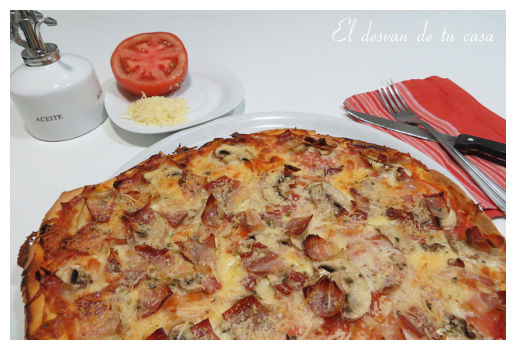


Image: 000000210548.jpg
Generated Caption: a little girl is sitting on a skateboard


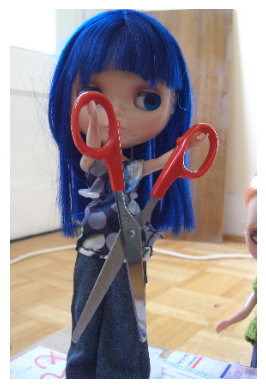


Image: 000000196829.jpg
Generated Caption: a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a sandwich has a


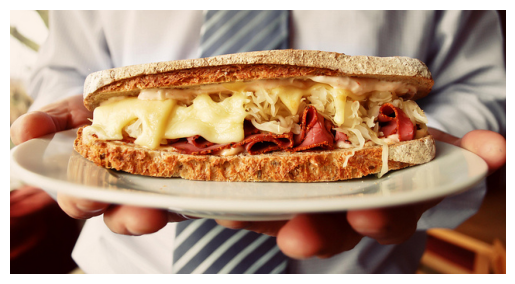

In [225]:
#Evaluate on Unseen Test Images
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define path to test images
test_img_dir = f"{BASE_PATH}/test2017"
test_img_list = os.listdir(test_img_dir)[:5]  # Load first 5 test images

# Display and caption test images
for test_img_name in test_img_list:
    img_path = os.path.join(test_img_dir, test_img_name)
    
    # Generate and display caption
    caption = generate_caption(img_path)  # from your existing model
    print(f"\nImage: {test_img_name}")
    print("Generated Caption:", caption)
    
    # Display the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


The test on the the unseen data above show's how the model end's up repeated the same words over and over sometimes. 

On certain images the model predicts accuractely the global context of the images, such as a girl being present and a motorcycle or a rusted bench. But doesn't understand all the details.

## 8. Model Persistence
Save our trained model components for future use and deployment.

In [226]:
# ✅ Save the model
cnn_encoder.save('cnn_encoder_model.keras')
decoder.save('decoder_model.keras')


# Hyperparameter Tuning 

In [1]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np
from typing import Dict, Any, Tuple
import json
import os
from datetime import datetime

In [2]:
def create_cnn_encoder():
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    base_model.trainable = False
    output = base_model.output
    output = tf.keras.layers.Reshape((-1, output.shape[-1]))(output)  # (batch, H*W, features)
    return tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
class TunableBahdanauAttention(tf.keras.Model):
    """Tunable version of BahdanauAttention with configurable parameters"""
    def __init__(self, units, dropout_rate=0.0, activation='tanh'):
        super().__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.activation = activation
        
    def call(self, features, hidden, training=None):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # Apply configurable activation function
        if self.activation == 'tanh':
            score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        elif self.activation == 'relu':
            score = tf.nn.relu(self.W1(features) + self.W2(hidden_with_time_axis))
        else:  # leaky_relu
            score = tf.nn.leaky_relu(self.W1(features) + self.W2(hidden_with_time_axis))
        
        score = self.dropout(score, training=training)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class TunableDecoder(tf.keras.Model):
    """Tunable version of Decoder with configurable parameters"""
    def __init__(self, embedding_dim, units, vocab_size, dropout_rate=0.0, 
                 recurrent_dropout=0.0, attention_dropout=0.0, attention_activation='tanh',
                 dense_activation='relu', use_layer_norm=False, num_lstm_layers=1):
        super().__init__()
        self.units = units
        self.num_lstm_layers = num_lstm_layers
        self.use_layer_norm = use_layer_norm
        
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        # LSTM layers
        self.lstm_layers = []
        for i in range(num_lstm_layers):
            return_sequences = True if i < num_lstm_layers - 1 else True
            return_state = True if i == num_lstm_layers - 1 else False
            
            lstm = tf.keras.layers.LSTM(
                units, 
                return_sequences=return_sequences, 
                return_state=return_state,
                dropout=dropout_rate,
                recurrent_dropout=recurrent_dropout
            )
            self.lstm_layers.append(lstm)
        
        # Dense layers
        self.fc1 = tf.keras.layers.Dense(units, activation=dense_activation)
        self.fc1_dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        # Attention mechanism
        self.attention = TunableBahdanauAttention(units, attention_dropout, attention_activation)
        
        # Layer normalization (optional)
        if use_layer_norm:
            self.layer_norm1 = tf.keras.layers.LayerNormalization()
            self.layer_norm2 = tf.keras.layers.LayerNormalization()
    
    def call(self, x, features, hidden, training=None):
        context_vector, attention_weights = self.attention(features, hidden, training=training)
        
        # Embedding
        x = self.embedding(x)
        x = self.embedding_dropout(x, training=training)
        
        # Concatenate context vector with embeddings
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # Apply layer normalization if enabled
        if self.use_layer_norm:
            x = self.layer_norm1(x, training=training)
        
        # Pass through LSTM layers
        states = []
        for i, lstm_layer in enumerate(self.lstm_layers):
            if i == len(self.lstm_layers) - 1:  # Last layer returns states
                x, state_h, state_c = lstm_layer(x, training=training)
                states = [state_h, state_c]
            else:
                x = lstm_layer(x, training=training)
        
        # Dense layers
        x = self.fc1(x)
        if self.use_layer_norm:
            x = self.layer_norm2(x, training=training)
        x = self.fc1_dropout(x, training=training)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        
        return x, states[0], attention_weights  # Return hidden state
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

class ImageCaptionHyperModel(kt.HyperModel):
    """Hypermodel for tuning image captioning model parameters"""
    
    def __init__(self, vocab_size, cnn_encoder=None):
        self.vocab_size = vocab_size
        self.cnn_encoder = cnn_encoder
    
    def build(self, hp):
        """Build model with hyperparameters"""
        
        # Decoder hyperparameters
        embedding_dim = hp.Int('embedding_dim', min_value=128, max_value=512, step=64)
        units = hp.Int('lstm_units', min_value=256, max_value=1024, step=128)
        
        # Dropout hyperparameters
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
        attention_dropout = hp.Float('attention_dropout', min_value=0.0, max_value=0.3, step=0.1)
        
        # Attention mechanism hyperparameters
        attention_activation = hp.Choice('attention_activation', ['tanh', 'relu', 'leaky_relu'])
        
        # Dense layer hyperparameters
        dense_activation = hp.Choice('dense_activation', ['relu', 'tanh', 'gelu'])
        
        # Architecture hyperparameters
        use_layer_norm = hp.Boolean('use_layer_norm')
        num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=3)
        
        # Learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        
        # Build decoder
        decoder = TunableDecoder(
            embedding_dim=embedding_dim,
            units=units,
            vocab_size=self.vocab_size,
            dropout_rate=dropout_rate,
            recurrent_dropout=recurrent_dropout,
            attention_dropout=attention_dropout,
            attention_activation=attention_activation,
            dense_activation=dense_activation,
            use_layer_norm=use_layer_norm,
            num_lstm_layers=num_lstm_layers
        )
        
        # Create a wrapper model for training
        model = CaptionModelWrapper(self.cnn_encoder, decoder, learning_rate)
        
        return model


In [ ]:
class CaptionModelWrapper(tf.keras.Model):
    """Wrapper model for training with Keras Tuner"""
    
    def __init__(self, cnn_encoder, decoder, learning_rate):
        super().__init__()
        self.cnn_encoder = cnn_encoder
        self.decoder_model = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
        # Optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        # Loss function
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none'
        )
    
    def compile(self, optimizer=None, loss=None, metrics=None, **kwargs):
        # Override compile to use custom training
        super().compile(**kwargs)
    
    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)
    
    @tf.function
    def train_step(self, data):
        img_tensor, target = data
        
        loss = 0
        hidden = self.decoder_model.reset_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([1] * target.shape[0], 1)  # Assuming start token is 1
        
        with tf.GradientTape() as tape:
            features = self.cnn_encoder(img_tensor, training=False)  # CNN frozen
            
            for i in range(1, target.shape[1]):
                predictions, hidden, _ = self.decoder_model(
                    dec_input, features, hidden, training=True
                )
                loss += self.loss_function(target[:, i], predictions)
                dec_input = tf.expand_dims(target[:, i], 1)
        
        total_loss = loss / int(target.shape[1])
        
        # Only train decoder variables
        trainable_vars = self.decoder_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker]


In [ ]:
class ImageCaptionTuner:
    """Main hyperparameter tuner class"""
    
    def __init__(self, vocab_size: int, cnn_encoder, project_name: str = "image_caption_tuning"):
        self.vocab_size = vocab_size
        self.cnn_encoder = cnn_encoder
        self.project_name = project_name
        self.best_params = None
        self.tuner = None
        self.max_trials = None  # Store max_trials for reference
    
    def create_tuner(self, 
                    tuner_type: str = 'bayesian',
                    max_trials: int = 50,
                    executions_per_trial: int = 1,
                    directory: str = 'hyperparameter_tuning',
                    overwrite: bool = False) -> kt.Tuner:
        """Create and configure the hyperparameter tuner"""
        
        self.max_trials = max_trials  # Store for reference
        hypermodel = ImageCaptionHyperModel(self.vocab_size, self.cnn_encoder)
        
        if tuner_type == 'bayesian':
            tuner = kt.BayesianOptimization(
                hypermodel,
                objective='loss',
                max_trials=max_trials,
                executions_per_trial=executions_per_trial,
                directory=directory,
                project_name=self.project_name,
                overwrite=overwrite
            )
        elif tuner_type == 'random':
            tuner = kt.RandomSearch(
                hypermodel,
                objective='loss',
                max_trials=max_trials,
                executions_per_trial=executions_per_trial,
                directory=directory,
                project_name=self.project_name,
                overwrite=overwrite
            )
        elif tuner_type == 'hyperband':
            tuner = kt.Hyperband(
                hypermodel,
                objective='loss',
                max_epochs=10,
                factor=3,
                directory=directory,
                project_name=self.project_name,
                overwrite=overwrite
            )
            # For Hyperband, max_trials is not directly set
            self.max_trials = "Variable (Hyperband)"
        else:
            raise ValueError(f"Unsupported tuner type: {tuner_type}")
        
        self.tuner = tuner
        return tuner
    
    def search(self, 
               train_dataset,
               validation_dataset=None,
               epochs: int = 10,
               callbacks: list = None) -> None:
        """Run hyperparameter search"""
        
        if self.tuner is None:
            raise ValueError("Tuner not created. Call create_tuner() first.")
        
        # Default callbacks
        if callbacks is None:
            callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
            ]
        
        # Get max trials from stored value
        max_trials = self.max_trials if self.max_trials else 'Unknown'
        print(f"Starting hyperparameter search with {max_trials} trials...")
        
        self.tuner.search(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        
        print("Hyperparameter search completed!")
    
    def get_best_hyperparameters(self, num_trials: int = 1) -> Dict[str, Any]:
        """Get the best hyperparameters from the search"""
        
        if self.tuner is None:
            raise ValueError("No tuner found. Run search() first.")
        
        best_hps = self.tuner.get_best_hyperparameters(num_trials=num_trials)
        self.best_params = best_hps[0].values if best_hps else None
        
        return self.best_params
    
    def get_best_model(self):
        """Get the best model from the search"""
        
        if self.tuner is None:
            raise ValueError("No tuner found. Run search() first.")
        
        return self.tuner.get_best_models(num_models=1)[0]
    
    def build_best_model(self) -> Tuple[TunableDecoder, Dict[str, Any]]:
        """Build the best model with optimal hyperparameters"""
        
        best_params = self.get_best_hyperparameters()
        
        if best_params is None:
            raise ValueError("No best parameters found. Run search() first.")
        
        # Build decoder with best parameters
        decoder = TunableDecoder(
            embedding_dim=best_params['embedding_dim'],
            units=best_params['lstm_units'],
            vocab_size=self.vocab_size,
            dropout_rate=best_params['dropout_rate'],
            recurrent_dropout=best_params['recurrent_dropout'],
            attention_dropout=best_params['attention_dropout'],
            attention_activation=best_params['attention_activation'],
            dense_activation=best_params['dense_activation'],
            use_layer_norm=best_params['use_layer_norm'],
            num_lstm_layers=best_params['num_lstm_layers']
        )
        
        return decoder, best_params
    
    def save_results(self, filepath: str = None):
        """Save tuning results to file"""
        
        if filepath is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filepath = f"tuning_results_{timestamp}.json"
        
        results = {
            'best_hyperparameters': self.get_best_hyperparameters(),
            'tuner_summary': self.tuner.results_summary() if self.tuner else None,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(filepath, 'w') as f:
            json.dump(results, f, indent=2, default=str)
        
        print(f"Results saved to {filepath}")
    
    def results_summary(self):
        """Print summary of tuning results"""
        
        if self.tuner is None:
            print("No tuner found. Run search() first.")
            return
        
        print("\n" + "="*50)
        print("HYPERPARAMETER TUNING RESULTS SUMMARY")
        print("="*50)
        
        # Best hyperparameters
        best_params = self.get_best_hyperparameters()
        if best_params:
            print("\nBest Hyperparameters:")
            print("-" * 30)
            for param, value in best_params.items():
                print(f"{param}: {value}")
        
        # Tuner summary
        print(f"\nTotal trials completed: {len(self.tuner.oracle.trials)}")
        self.tuner.results_summary()

In [ ]:
def example_usage(vocab_size):
    """Example of how to use the ImageCaptionTuner"""
    
    # Assuming you have your CNN encoder and dataset ready
    cnn_encoder = create_cnn_encoder()  # Your existing CNN encoder
    
    # Create tuner
    tuner = ImageCaptionTuner(vocab_size, cnn_encoder)
    
    # Create and configure the hyperparameter tuner
    kt_tuner = tuner.create_tuner(
        tuner_type='bayesian',
        max_trials=30,
        directory='tuning_results'
    )
    
    # Run search
    tuner.search(
        train_dataset,  # Your training dataset
        val_dataset,  # Your validation dataset
        epochs=5
    )
    
    # Get results
    best_decoder, best_params = tuner.build_best_model()
    tuner.results_summary()
    tuner.save_results()

    return best_decoder, best_params

### Running Hyperparameter Optimization
Execute the comprehensive hyperparameter tuning process to find optimal model configuration. This will systematically test different combinations of parameters to improve model performance.

In [ ]:
example_usage(10000)  